In [1]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns

from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os, sys, shutil, copy, time, random
from functools import partial

from sustain_dataset import *
from models import *
from utils import *

In [2]:
class Args:
    def __init__(self):
        self.log_root = './runs/unbiased'
        self.dataset = "gdp"

        self.train_bias_y = False
        self.train_bias_f = False
        self.train_cons = False
        self.train_calib = False
        self.re_calib = True
        self.re_bias_f = True
        self.re_bias_y = True

        # Modeling parameters
        self.model = 'small' #'linear' #'big'
        self.learning_rate = 1e-3
        self.batch_size = 1024
        self.num_bins = 0
        self.knn = 100

        # Run related parameters
        self.gpu = 0
        self.num_epoch = 500
        self.run_label = 0
        self.num_run = 10

args = Args()

device = torch.device('cuda:%d' % args.gpu)
args.device = device

In [3]:
args.knn = 200
class RecalibratorBias:
    def __init__(self, model, data, args, train=True, axis='label', verbose=False):
        self.axis = axis
#         self.flow = deeper_flow(layer_num=5, feature_size=20).to(args.device) 
        self.flow = NafFlow().to(args.device) # This flow model is too simple, might need more layers and latents?
        flow_optim = optim.Adam(self.flow.parameters(), lr=1e-3)
        
        k = args.knn
        assert k % 2 == 0
        
        inputs, labels = data
        inputs = inputs.to(args.device)
        labels = labels.to(args.device).flatten()
        
        if train:
            for iteration in range(5000):
                flow_optim.zero_grad()
                outputs = model(inputs).flatten()

                if axis == 'label':
                    ranking = torch.argsort(labels)
                else:
                    assert axis == 'prediction'
                    ranking = torch.argsort(outputs)

                sorted_labels = labels[ranking]
                sorted_outputs = outputs[ranking]

                smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                            weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                            padding=0).flatten()
                smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                                           weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                           padding=0).flatten()
                
                adjusted_outputs, _ = self.flow(smoothed_outputs.view(-1, 1))
                loss_bias = (smoothed_labels - adjusted_outputs.view(-1)).pow(2).mean()
                loss_bias.backward()
                flow_optim.step()

                if verbose and iteration % 100 == 0:
                    print("Iteration %d, loss_bias=%.5f" % (iteration, loss_bias))
    
    def adjust(self, original_y):
        original_shape = original_y.shape
#        if self.axis == 'label':
#             adjusted_output = self.flow.invert(original_y.view(-1, 1))
#         else:
        adjusted_output, _ = self.flow(original_y.view(-1, 1))
        return adjusted_output.view(original_shape)
    

In [4]:
class Recalibrator:
    # This class is untested 
    def __init__(self, model, data, args, train=True, re_calib=False, re_bias_f=False, re_bias_y=False, verbose=False):
        self.args = args
        self.re_calib = re_calib
        self.re_bias_f = re_bias_f 
        self.re_bias_y = re_bias_y
        self.model = model  # regression model        
        self.flow = NafFlow(feature_size=40).to(args.device) # This flow model is too simple, might need more layers and latents?
        flow_optim = optim.Adam(self.flow.parameters(), lr=1e-3)
        # flow_scheduler = torch.optim.lr_scheduler.StepLR(flow_optim, step_size=100, gamma=0.9)

        k = args.knn
        assert k % 2 == 0
        assert re_calib or re_bias_f or re_bias_y 
        
        inputs, labels = data
        inputs = inputs.to(self.args.device)
        labels = labels.to(self.args.device).flatten()
        
        if train:
            for iteration in range(5000):
                flow_optim.zero_grad()
                loss_all = 0.0
                outputs = model(inputs).flatten()

                for objective in range(2):
                    if objective == 0 and self.re_bias_f:
                        ranking = torch.argsort(outputs)
                    elif objective == 1 and self.re_bias_y:
                        ranking = torch.argsort(labels)
                    else:
                        continue
                    sorted_labels = labels[ranking]
                    sorted_outputs = outputs[ranking]

                    smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                                weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                                padding=k // 2).flatten()
                    smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                                               weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                               padding=k // 2).flatten()
                    adjusted_outputs, _ = self.flow(smoothed_outputs.view(-1, 1))
                    loss_bias = (smoothed_labels - adjusted_outputs.view(-1)).pow(2).mean()
                    loss_all += loss_bias 

                if re_calib:
                    labels = torch.sort(labels.flatten())[0]
                    outputs = torch.sort(outputs.flatten())[0]
                    adjusted_outputs, _ = self.flow(outputs.view(-1, 1))
                    loss_bias = (labels - adjusted_outputs.view(-1)).pow(2).mean()
                    loss_all += loss_bias

                loss_all.backward()
                flow_optim.step()
                # flow_scheduler.step()
                if verbose and iteration % 100 == 0:
                    print("Iteration %d, loss_bias=%.5f" % (iteration, loss_bias))
    
    def adjust(self, original_y):
        original_shape = original_y.shape
        adjusted_output, _ = self.flow(original_y.view(-1, 1))
        return adjusted_output.view(original_shape)


In [8]:
def plot_knn(model, data, args, axis='label'):
    k = args.knn
    assert k % 2 == 0

    inputs, labels = data
    inputs = inputs.to(args.device)
    labels = labels.to(args.device).flatten()
    outputs = model(inputs).flatten()

    if axis == 'label':
        ranking = torch.argsort(labels)
    else:
        assert axis == 'prediction'
        ranking = torch.argsort(outputs)

    sorted_labels = labels[ranking]
    sorted_outputs = outputs[ranking]

    smoothed_outputs = F.conv1d(sorted_outputs.view(1, 1, -1), 
                                weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                                padding=k // 2).flatten()
    smoothed_labels = F.conv1d(sorted_labels.view(1, 1, -1), 
                               weight=(1./ (k+1) * torch.ones(1, 1, k+1, device=args.device, requires_grad=False)),
                               padding=k // 2).flatten()
    return smoothed_labels[k//2+1:-k//2-1], smoothed_outputs[k//2+1:-k//2-1]

def plot_calibration(model, data, args):
    inputs, labels = data
    inputs = inputs.to(args.device)
    labels = labels.to(args.device)
    
    outputs = model(inputs)
    
    labels, _ = torch.sort(labels.flatten())
    outputs, _ = torch.sort(outputs.flatten())
    return labels, outputs

def smooth(y, box_pts=100):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

In [65]:
def tax_utility(difference, beta=1.):
    # difference: y_0 - pred
    return beta * difference


def compute_utility(model, test_dataset, groundtruth=False, a=torch.relu, r=torch.log, y_0=0.3):
    inputs, labels = test_dataset[:]
    inputs, labels = inputs.to(device), labels.to(device)
    pred = model(inputs).reshape(-1)
    labels = labels.reshape(-1)
    finacial_aid = a(y_0 - pred)
    true_aid = a(y_0 - labels) 
    after_finacial_aid = labels + finacial_aid
    # utility = r(2.+after_finacial_aid) # worked well
    utility = r(3.+after_finacial_aid)
    utility = utility.mean(dim=0)
    if not groundtruth:
        return utility.data.item(), finacial_aid.sum().data.item()
    return utility.data.item(), true_aid.data.cpu() - finacial_aid.data.cpu()


# original
def plot_errbar_original(ax, x, y, c=None, label=None):
    mean = np.mean(y, axis=1)
    std = np.std(y, axis=1) / np.sqrt(y.shape[1])
    ax.plot(x, mean, label=label, c=c, linewidth=2.)
    ax.fill_between(x, mean-std, mean+std, color=c, alpha=0.01)

    
from scipy.interpolate import interp1d
def plot_errbar(ax, x, y, x1=600, x2=2000, c=None, label=None):
    for i in range(y.shape[1]):
        f2 = interp1d(x[:, i], y[:, i], kind='linear')
        y[:, i] = f2(np.linspace(x1, x2, len(x)))

    mean = np.mean(y, axis=1)
    std = np.std(y, axis=1) / np.sqrt(y.shape[1])
    x = np.linspace(x1, x2, len(mean))
    ax.plot(x, mean, label=label, c=c, linewidth=3.)
    return x, mean
    # ax.fill_between(x, mean-std, mean+std, color=c, alpha=0.01)
    
    
def compute_y0(testdata, total_aid=500, small_y0=-0.5, large_y0=2., act=torch.relu, r=torch.log):
    y0_array = []
    total_array = []
    # sample points of the function
    for y0 in np.linspace(small_y0, large_y0, 100):
        u, a = compute_utility(model, test_dataset, y_0=y0, a=act, r=r)
        total_array.append(a)
        y0_array.append(y0)
    total_array = np.array(total_array)
    y0_array = np.array(y0_array)
     # fit the function
    f2 = interp1d(total_array, y0_array, kind='linear')
    y0_pred = f2(total_aid)
    return y0_pred  

/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/atlas/u/chenlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

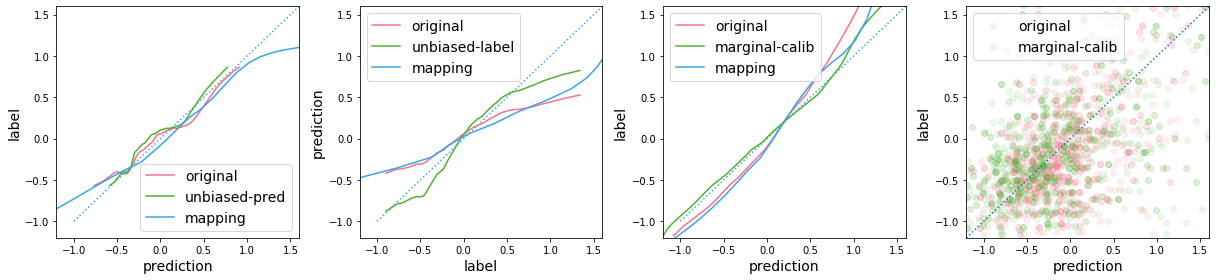

In [66]:
args.knn = 100
utility_points = 100
run_labels = np.arange(0, 1, 1)
for i, train_bias_y in enumerate([True, False]):
    for j, train_bias_f in enumerate([True, False]):
        for k, train_cons in enumerate([True, False]):
            for t, train_calib in enumerate([True, False]):

                # test_utility = np.zeros((utility_points + 18, len(run_labels)))
                test_utility = np.zeros((utility_points, len(run_labels)))
                test_labels = np.zeros((utility_points, len(run_labels)))

                labels_bias = None
                for run_label in run_labels:
                    args.name = '%s_knn/recalibration_model=%s-%r-%r-%r-%r-%r-%r-%r-bs=%d-bin=%d-%d-run=%d' % \
                            (args.dataset, args.model,
                             args.train_bias_y, args.train_bias_f, args.train_cons, args.train_calib, args.re_calib,
                             args.re_bias_f, args.re_bias_y,
                             args.batch_size, args.num_bins, args.knn, args.run_label)

                    args.log_dir = os.path.join(args.log_root, args.name)
                    if not os.path.isdir(args.log_dir):
#                         print("dir not exist {}".format(args.name))
                        continue

                    ckpt = torch.load(os.path.join(args.log_dir, "ckpt.pth"))
                    train_dataset = ckpt[1]
                    test_dataset = ckpt[2]
                    val_dataset = ckpt[3]

                    # Define model and optimizer
                    model = model_list[args.model](train_dataset.x_dim).to(device)
                    # model = model_list[args.model](train_dataset.x_dim, act=F.tanh).to(device)
                    model.load_state_dict(ckpt[0])
                    
                    args.knn = 200
                    recalibrator_bias_f = RecalibratorBias(model, val_dataset[:], args, train=False, axis='prediction', verbose=True)
                    recalibrator_bias_y = RecalibratorBias(model, val_dataset[:], args, train=False, axis='label', verbose=True)
                    recalibrator_calib = Recalibrator(model, val_dataset[:], args, train=False, re_calib=True, verbose=True)
                    
                    recalibrator_bias_f.flow.load_state_dict(ckpt[5])
                    recalibrator_bias_y.flow.load_state_dict(ckpt[6])
                    recalibrator_calib.flow.load_state_dict(ckpt[7])
                    

                    model.eval()
                    import seaborn as sns
                    palette = sns.color_palette('husl', 3)

                    plot_lim = [-1.2, 1.6]
                    fontsize = 14
                    x = torch.linspace(val_dataset[:][1].min(), val_dataset[:][1].max(), 200).to(device)
                    with torch.no_grad():
                        plt.figure(figsize=(17, 4))
                        model.recalibrator = None

                        plt.subplot(1, 4, 1)
                        labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
                        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original') 
                        plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
                        plt.xlabel('prediction', fontsize=fontsize)
                        plt.ylabel('label', fontsize=fontsize)
                        plt.xlim(plot_lim)
                        plt.ylim(plot_lim)

                        plt.subplot(1, 4, 2)
                        labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
                        plt.plot(smooth(labels.cpu()), smooth(outputs.cpu()), c=palette[0], label='original') 
                        plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
                        plt.xlabel('label', fontsize=fontsize)
                        plt.ylabel('prediction', fontsize=fontsize) 
                        plt.xlim(plot_lim)
                        plt.ylim(plot_lim)

                        plt.subplot(1, 4, 3)
                        labels, outputs = plot_calibration(model, test_dataset[:], args)
                        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[0], label='original')
                        plt.plot([-1.0, 2.0], [-1.0, 2.0], linestyle=':', c=palette[2])
                        plt.xlabel('prediction', fontsize=fontsize) 
                        plt.ylabel('label', fontsize=fontsize)
                        plt.xlim(plot_lim)
                        plt.ylim(plot_lim)


                        plt.subplot(1, 4, 1)
                        model.recalibrator = recalibrator_bias_f
                        labels, outputs = plot_knn(model, test_dataset[:], args, axis='prediction')
                        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[1], label='unbiased-pred') 
                        y = recalibrator_bias_f.adjust(x.view(-1, 1))
                        plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
                        plt.legend(fontsize=fontsize)

                        plt.subplot(1, 4, 2)
                        model.recalibrator = recalibrator_bias_y
                        labels, outputs = plot_knn(model, test_dataset[:], args, axis='label')
                        plt.plot(smooth(labels.cpu()), smooth(outputs.cpu()), c=palette[1], label='unbiased-label') 
                        y = recalibrator_bias_y.adjust(x.view(-1, 1))
                        plt.plot(y.detach().cpu(), x.cpu(), c=palette[2], label='mapping')
                        plt.legend(fontsize=fontsize)

                        plt.subplot(1, 4, 3)
                        model.recalibrator = recalibrator_calib
                        labels, outputs = plot_calibration(model, test_dataset[:], args)
                        plt.plot(smooth(outputs.cpu()), smooth(labels.cpu()), c=palette[1], label='marginal-calib')
                        y = recalibrator_calib.adjust(x.view(-1, 1))
                        plt.plot(x.cpu(), y.detach().cpu(), c=palette[2], label='mapping')
                        plt.legend(fontsize=fontsize)

                        plt.subplot(1, 4, 4)
                        model.recalibrator = None
                        inputs, labels = val_dataset[:]
                        inputs = inputs.to(args.device)
                        labels = labels.to(args.device).flatten()
                        outputs = model(inputs)
                        adjusted_outputs = recalibrator_calib.adjust(outputs)
                        idx = np.random.choice(np.arange(len(labels)), 1000)
                        plt.scatter(outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[0], label='original')
                        plt.scatter(adjusted_outputs.cpu()[idx], labels.cpu()[idx], alpha=0.1, c=palette[1], label='marginal-calib')
                        plt.plot([-1.5, 2.0], [-1.5, 2.0], linestyle=':')
                        plt.xlim(plot_lim)
                        plt.ylim(plot_lim)
                        plt.xlabel('prediction', fontsize=fontsize) 
                        plt.ylabel('label', fontsize=fontsize)
                        plt.legend(fontsize=fontsize)
                        plt.tight_layout()
#                         plt.savefig('plots/recalib_curve.png')

                        plt.show()

    

In [72]:
from scipy.interpolate import interp1d
def plot_errbar_div(ax, x, y, x1=400, x2=3000, c=None, label=None, require_div=False, y_0=1.):
    for i in range(y.shape[1]):
        f2 = interp1d(x[:, i], y[:, i], kind='linear')
        y[:, i] = f2(np.linspace(x1, x2, len(x)))

    mean = np.mean(y, axis=1)
    std = np.std(y, axis=1) / np.sqrt(y.shape[1])
    x = np.linspace(x1, x2, len(mean))

    if require_div:
        ax.plot(x, mean/y_0, label=label, c=c, linewidth=3.)
    # ax.fill_between(x, mean-std, mean+std, color=c, alpha=0.01)
    else:
        ax.plot(x, mean/mean, label=label, c=c, linewidth=3.)
    return x, mean
    
    

(array([0.995, 0.996, 0.997, 0.998, 0.999, 1.   , 1.001, 1.002]),
 <a list of 8 Text yticklabel objects>)

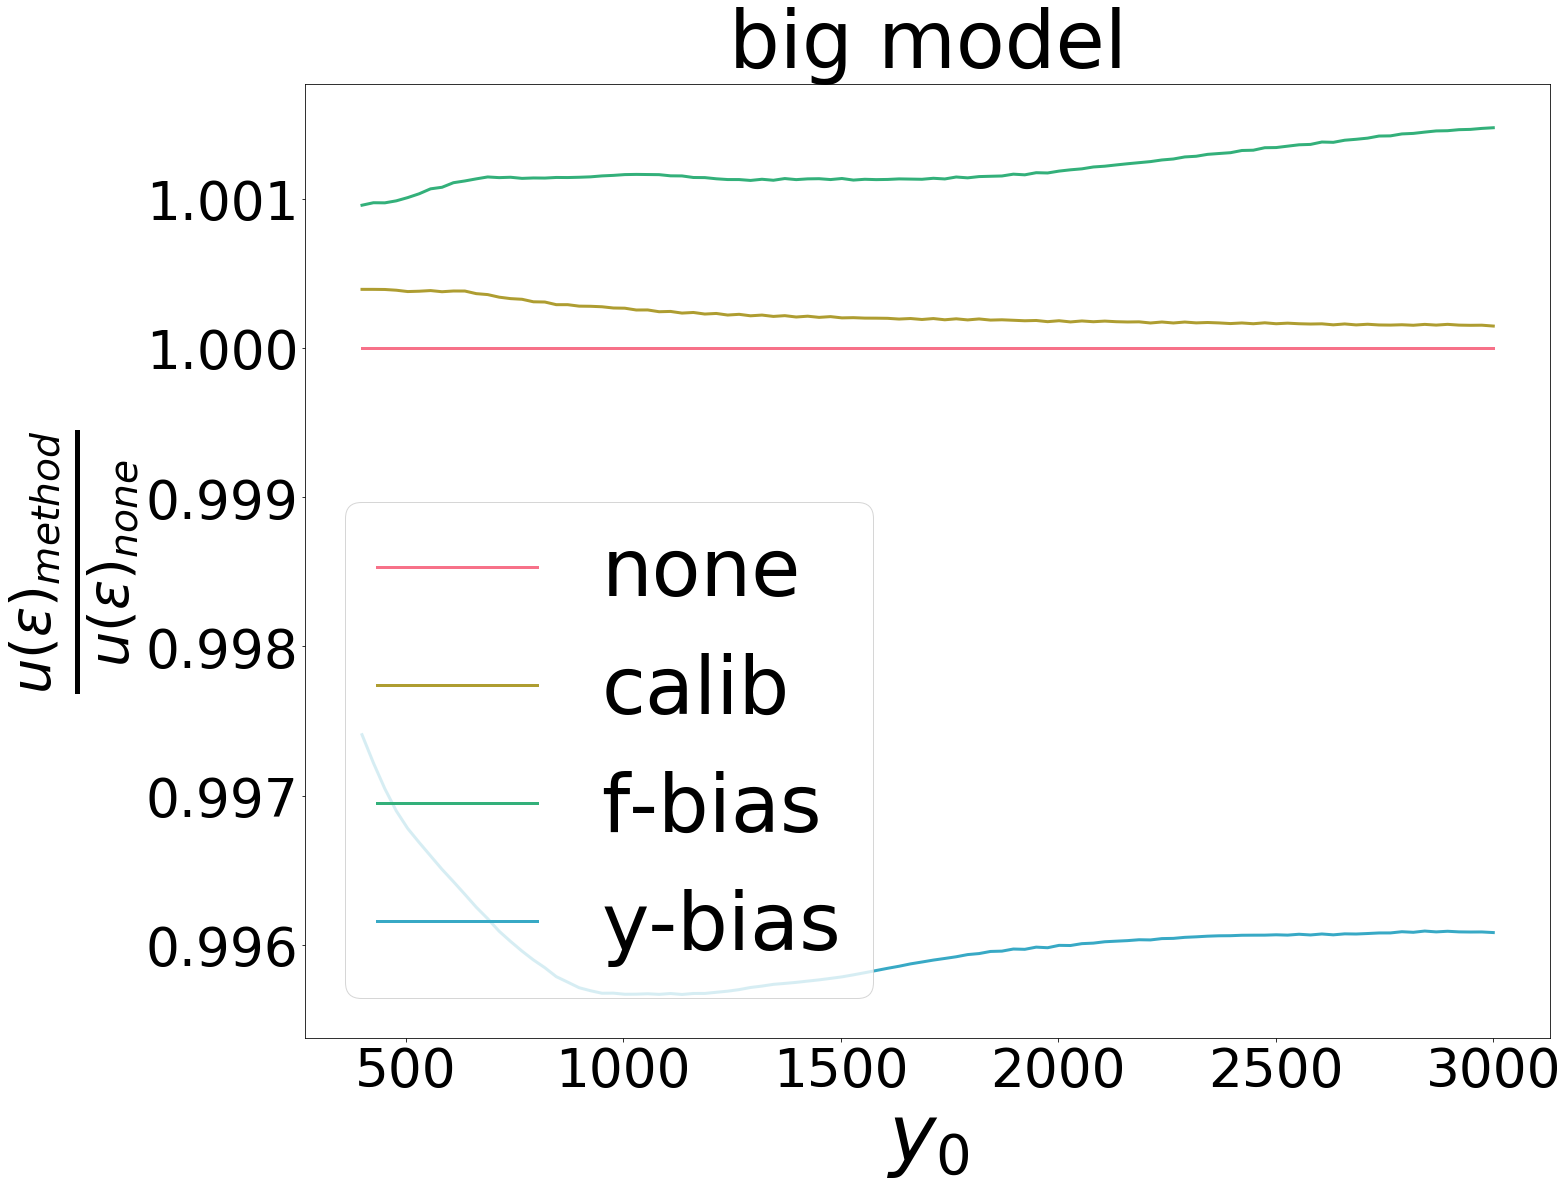

In [76]:
args = Args()
args.knn = 100
args.model = "big" #"linear" #"big"

device = torch.device('cuda:%d' % args.gpu)
args.device = device
start_time = time.time()
run_labels = range(0, 10, 1)
utility_points = 100
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 16))
colors = sns.color_palette('husl', 5)
# colors = plt.cm.get_cmap('Set3').colors
# colors = ['r', 'g', 'c', 'm', 'k', 'orange', 'r', 'black']

for i in range(4):
    if i == 0:
        label_ = "none"
        re_bias_y = re_bias_f = re_calib = False
    elif i == 1:
        label_ = "calib"
        re_calib = True
        re_bias_y = re_bias_f = False
    elif i == 2:
        label_ = 'f-bias'
        re_bias_f = True
        re_bias_y = re_calib = False
    elif i == 3:
        label_ = 'y-bias'
        re_bias_y = True
        re_bias_f = re_calib = False
   
   
    test_utility = np.zeros((utility_points, len(run_labels)))
    test_labels = np.zeros((utility_points, len(run_labels)))

    labels_bias = None
    for run_label in run_labels:
        args.knn = 100
        args.name = '%s_knn/recalibration_model=%s-%r-%r-%r-%r-%r-%r-%r-bs=%d-bin=%d-%d-run=%d' % \
                (args.dataset, args.model,
                 False, False, False, False, args.re_calib,
                 args.re_bias_f, args.re_bias_y,
                 args.batch_size, args.num_bins, args.knn, args.run_label)

        args.log_dir = os.path.join(args.log_root, args.name)
        if not os.path.isdir(args.log_dir):
            print("dir not exist {}".format(args.name))
            continue

        ckpt = torch.load(os.path.join(args.log_dir, "ckpt.pth"))
        train_dataset = ckpt[1]
        test_dataset = ckpt[2]
        val_dataset = ckpt[3]

        # Define model and optimizer
        model = model_list[args.model](train_dataset.x_dim).to(device)
        # model = model_list[args.model](train_dataset.x_dim, act=F.tanh).to(device)
        model.load_state_dict(ckpt[0])

        args.knn = 200
        recalibrator_bias_f = RecalibratorBias(model, val_dataset[:], args, train=False, axis='prediction', verbose=True)
        recalibrator_bias_y = RecalibratorBias(model, val_dataset[:], args, train=False, axis='label', verbose=True)
        recalibrator_calib = Recalibrator(model, val_dataset[:], args, train=False, re_calib=True, verbose=True)

        recalibrator_bias_f.flow.load_state_dict(ckpt[5])
        recalibrator_bias_y.flow.load_state_dict(ckpt[6])
        recalibrator_calib.flow.load_state_dict(ckpt[7])
        model.recalibrator = None
        
        model.eval()
        if re_bias_y:
            model.recalibrator = recalibrator_bias_y
        elif re_bias_f:
            model.recalibrator = recalibrator_bias_f
        elif re_calib:
            model.recalibrator = recalibrator_calib
            
        # Performance evaluation
        with torch.no_grad():
            u_array_bias = []
            labels_bias = []

            for y0 in np.linspace(-1.5, 2, utility_points):
                u, a = compute_utility(model, test_dataset, y_0=y0)
                # u, a = compute_utility(model, test_dataset, r=(lambda x: torch.pow(x, 1/2.)), y_0=y0)
                u_array_bias.append(u)
                labels_bias.append(a)

        test_utility[:utility_points, run_label] = np.array(u_array_bias) #smooth(np.array(u_array_bias), 18)
        test_labels[:utility_points, run_label] = np.array(labels_bias)
      
    if isinstance(labels_bias, type(None)):
        continue

    if i == 0:
        _, y_0 = plot_errbar_div(ax1, test_labels[:utility_points], test_utility[:utility_points],
                label=label_, c=colors[i])
    else:
        plot_errbar_div(ax1, test_labels[:utility_points], test_utility[:utility_points],
                label=label_, c=colors[i], require_div=True, y_0=y_0)


# ax1.set_ylim([0.6, 1.5])
# ax1.set_ylim([1., 1.5])
fontsize = 80
if args.dataset == "gdp":
#     ax1.set_title("China GDP per capita prediction ({})".format(args.model), fontsize=fontsize)
    ax1.set_title("{} model".format(args.model), fontsize=fontsize)
else:
    ax1.set_title("Uganda poverty prediction", fontsize=fontsize)

ax1.legend(fontsize=fontsize)
ax1.set_xlabel(r"$y_0$", fontsize=fontsize)
ax1.set_ylabel(r"$\frac{u(\epsilon)_{method}}{u(\epsilon)_{none}}$", fontsize=fontsize)

plt.tight_layout()
plt.xticks(fontsize=fontsize/1.5)
plt.yticks(fontsize=fontsize/1.5)
# plt.savefig('plots/result_{}_knn.png'.format(args.dataset))
# plt.close()

In [126]:
args = Args()
args.knn = 100
args.model = "small"

device = torch.device('cuda:%d' % args.gpu)
args.device = device
start_time = time.time()
run_labels = range(0, 10, 1)
utility_points = 100
# fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
# colors = plt.cm.get_cmap('Set3').colors
# colors = ['r', 'g', 'c', 'm', 'k', 'orange', 'r', 'black']

# y0 = 0.
assistance_errors = []

total_aid = 1000

for i in range(4):
    if i == 0:
        re_bias_y = re_bias_f = re_calib = False
    elif i == 3:
        re_bias_y = True
        re_bias_f = re_calib = False
    elif i == 2:
        re_bias_f = True
        re_bias_y = re_calib = False
    elif i == 1:
        re_calib = True
        re_bias_y = re_bias_f = False
        
#     assistance_error = np.zeros((utility_points, len(run_labels)))
    error_ = []
    for _ in range(5):
        error_.append([])
    for run_label in run_labels:
        args.knn = 100
        args.name = '%s_knn/recalibration_model=%s-%r-%r-%r-%r-%r-%r-%r-bs=%d-bin=%d-%d-run=%d' % \
                (args.dataset, args.model,
                 False, False, False, False, args.re_calib,
                 args.re_bias_f, args.re_bias_y,
                 args.batch_size, args.num_bins, args.knn, args.run_label)

        args.log_dir = os.path.join(args.log_root, args.name)
        if not os.path.isdir(args.log_dir):
            print("dir not exist {}".format(args.name))
            continue

        ckpt = torch.load(os.path.join(args.log_dir, "ckpt.pth"))
        train_dataset = ckpt[1]
        test_dataset = ckpt[2]
        val_dataset = ckpt[3]

        # Define model and optimizer
        model = model_list[args.model](train_dataset.x_dim).to(device)
        # model = model_list[args.model](train_dataset.x_dim, act=F.tanh).to(device)
        model.load_state_dict(ckpt[0])

        args.knn = 200
        recalibrator_bias_f = RecalibratorBias(model, val_dataset[:], args, train=False, axis='prediction', verbose=True)
        recalibrator_bias_y = RecalibratorBias(model, val_dataset[:], args, train=False, axis='label', verbose=True)
        recalibrator_calib = Recalibrator(model, val_dataset[:], args, train=False, re_calib=True, verbose=True)

        recalibrator_bias_f.flow.load_state_dict(ckpt[5])
        recalibrator_bias_y.flow.load_state_dict(ckpt[6])
        recalibrator_calib.flow.load_state_dict(ckpt[7])
        model.recalibrator = None
        
        model.eval()
        if re_bias_y:
            model.recalibrator = recalibrator_bias_y
        elif re_bias_f:
            model.recalibrator = recalibrator_bias_f
        elif re_calib:
            model.recalibrator = recalibrator_calib
#             import pdb
#             pdb.set_trace()
        partition = [-100, -0.6, -0.32, 0. , 0.55, 100]
        # small_y0=-0.5
        y0 = (compute_y0(test_dataset, total_aid=total_aid, small_y0=-1.5, large_y0=2., act=torch.relu, r=torch.log)).item()
        print(y0)
        for j in range(5):
            inputs, labels = test_dataset[:]
            mask = (labels > partition[j]).squeeze()  # all the data with gdp labels<-0.5

            labels = labels[mask].to(device)
            inputs = inputs[mask].to(device)
            mask = (labels < partition[j+1]).squeeze()
            labels = labels[mask].to(device)
            inputs = inputs[mask].to(device)
            
            # Performance evaluation
            with torch.no_grad():
                _, error = compute_utility(model, [inputs, labels], groundtruth=True, y_0=y0)
                error_[j].extend(error)
    
    assistance_errors.append(error_)

0.4330715022336929
0.4330715022336929
0.4330715022336929
0.4330715022336929
0.4330715022336929
0.4330715022336929
0.4330715022336929
0.4330715022336929
0.4330715022336929
0.4330715022336929
0.29850539164715195
0.29850539164715195
0.29850539164715195
0.29850539164715195
0.29850539164715195
0.29850539164715195
0.29850539164715195
0.29850539164715195
0.29850539164715195
0.29850539164715195
0.43509231593899594
0.43509231593899594
0.43509231593899594
0.43509231593899594
0.43509231593899594
0.43509231593899594
0.43509231593899594
0.43509231593899594
0.43509231593899594
0.43509231593899594
0.059373501416723436
0.059373501416723436
0.059373501416723436
0.059373501416723436
0.059373501416723436
0.059373501416723436
0.059373501416723436
0.059373501416723436
0.059373501416723436
0.059373501416723436


4
small 1000


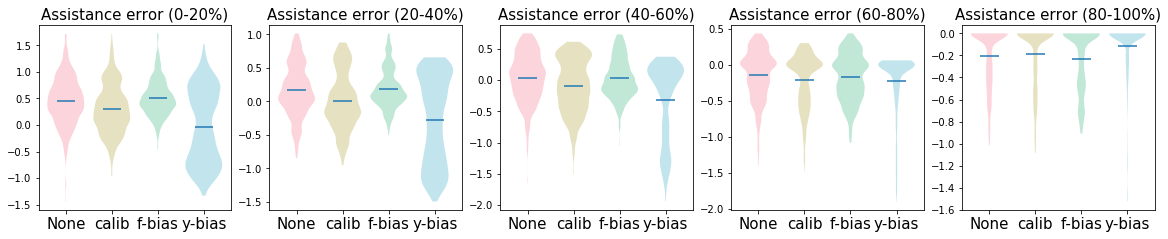

In [127]:
print(len(assistance_errors))
palette = sns.color_palette('husl', 5)
plt.figure(figsize=(20, 3.4))

fontsize=15
from matplotlib.ticker import FormatStrFormatter
grouped_results = []

for i in range(5):
    for j in range(4):
        grouped_results.append(assistance_errors[j][i])
    
for i in range(5):
    plt.subplot(1, 5, i+1)
    violin_parts = plt.violinplot(grouped_results[i*4:(i+1)*4], 
    #                    positions=range(5), 
                   positions=np.arange(4),
                   widths=0.8, showmeans=True, showextrema=False)
    for vi, vp in enumerate(violin_parts['bodies']):
#         vi = vi % 4
        vp.set_facecolor(palette[vi])

    labels = ['None', 'calib', 'f-bias', 'y-bias']
    x_labels = ["0","20", "40", "60", "80", "100"]
    plt.gca().set_xticks(np.arange(4))
    plt.gca().set_xticklabels(labels, fontsize=fontsize)
#     plt.ylim(-3, 2.6)
    plt.title("Assistance error ({}-{}%)".format(x_labels[i], x_labels[i+1]), fontsize=fontsize)
print(args.model, total_aid)

In [84]:
len(grouped_results)

20